# Read and plot sections in an OQ input model

See also https://github.com/gem/oq-engine/blob/master/openquake/hazardlib/tests/sourceconverter_test.py#L500

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely import Polygon, LineString
from openquake.hazardlib.sourceconverter import SourceConverter
from openquake.hazardlib.nrml import to_python

In [2]:
sconv = SourceConverter(investigation_time=50.0,
                        rupture_mesh_spacing=1.0,
                        width_of_mfd_bin=1.0)

In [3]:
# fname = '/home/chrisdc/NSHM/oqruns/test_oq`_converter_fromMP/sources/sources-7fa8d56.xml'
# fname_sections = '/home/chrisdc/NSHM/oqrun`s/test_oq_converter_fromMP/sources/sources-7fa8d56_sections.xml'
fname = "/home/chrisdc/tmp/convert/U2NhbGVkSW52ZXJzaW9uU29sdXRpb246MTIwNjk4-ruptures.xml"
fname_sections = "/home/chrisdc/tmp/convert/U2NhbGVkSW52ZXJzaW9uU29sdXRpb246MTIwNjk4-ruptures_sections.xml"
ssm = to_python(fname, sconv)

# Returns a `GeometryModel` instance
geom_model = to_python(fname_sections, sconv)

In [4]:
# Take the multi-fault source
src = ssm.src_groups[0][0]

In [5]:
# Get the sections
secs = geom_model.sections
s2i = {suid: i for i, suid in enumerate(secs)}

# Set the rupture IDs
src.rupture_idxs = [tuple(s2i[idx] for idx in idxs) for idxs in src.rupture_idxs]

In [6]:
# Add the sections to the source
src.set_sections(list(secs.values()))

In [7]:
def plot_mesh_2d(fig, smsh):
    """ Plots the mesh """
    for i in range(smsh.mesh.lons.shape[0]):
        #print(smsh.mesh.lons[i, :])
        fig.plot(x=smsh.mesh.lons[i, :], y=smsh.mesh.lats[i, :], pen="1p,red")
    for i in range(smsh.mesh.lons.shape[1]):
        fig.plot(x=smsh.mesh.lons[:, i], y=smsh.mesh.lats[:, i], pen="1p,red")
    fig.plot(x=smsh.mesh.lons[0, :], y=smsh.mesh.lats[0, :], pen="2p,green")
    
def plot_boundary_2d(fig, smsh):
    """ Plots the boundary """
    out = []

    # fig.plot(x=smsh.mesh.lons[0, :], y=smsh.mesh.lats[0, :], pen="1p,red")
    idx = np.isfinite(smsh.mesh.lons[-1, :])
    fig.plot(x=smsh.mesh.lons[-1, idx], y=smsh.mesh.lats[-1, idx], pen="1p,red")

    idx = np.isfinite(smsh.mesh.lons[:, 0])
    fig.plot(x=smsh.mesh.lons[idx, 0], y=smsh.mesh.lats[idx, 0], pen="1p,red")
    
    idx = np.isfinite(smsh.mesh.lons[:, -1])
    fig.plot(x=smsh.mesh.lons[idx, -1], y=smsh.mesh.lats[idx, -1], pen="1p,red")
    
    idx = np.isfinite(smsh.mesh.lons[0, :])
    fig.plot(x=smsh.mesh.lons[0, idx], y=smsh.mesh.lats[0, idx], pen="2p,green")
    
def get_boundary_2d(smsh):
    """ Returns a polygon """
    poly = []
    coo = []

    # Upper boundary + trace
    idx = np.where(np.isfinite(smsh.mesh.lons[0, :]))[0]
    tmp = [(smsh.mesh.lons[0, i], smsh.mesh.lats[0, i]) for i in idx]
    trace = LineString(tmp)
    coo.extend(tmp)

    # Right boundary
    idx = np.where(np.isfinite(smsh.mesh.lons[:, -1]))[0]
    tmp = [(smsh.mesh.lons[i, -1], smsh.mesh.lats[i, -1]) for i in idx]
    coo.extend(tmp)
    
    # Lower boundary
    idx = np.where(np.isfinite(smsh.mesh.lons[-1, :]))[0]
    tmp = [(smsh.mesh.lons[-1, i], smsh.mesh.lats[-1, i]) for i in np.flip(idx)]
    coo.extend(tmp)
    
    # Left boundary
    idx = idx = np.where(np.isfinite(smsh.mesh.lons[:, 0]))[0]
    tmp = [(smsh.mesh.lons[i, 0], smsh.mesh.lats[i, 0]) for i in np.flip(idx)]
    coo.extend(tmp)
    
    return trace, Polygon(coo)

In [8]:
traces = []
polys = []
suids = []
for i, key in enumerate(secs):
    print(f'Reading {i:05d}/{len(secs)-1:05d}', end='\r')
    tmp = secs[key]
    trace, poly = get_boundary_2d(tmp)
    traces.append(trace)
    polys.append(poly)
    suids.append(tmp.suid)
print('\n\n')
 
daf = pd.DataFrame({'suid': suids, 'geometry': polys})
gdaf_polys = gpd.GeoDataFrame(daf, geometry='geometry') 
daf = pd.DataFrame({'suid': suids, 'geometry': traces})
gdaf_traces = gpd.GeoDataFrame(daf, geometry='geometry') 

Reading 02324/02324




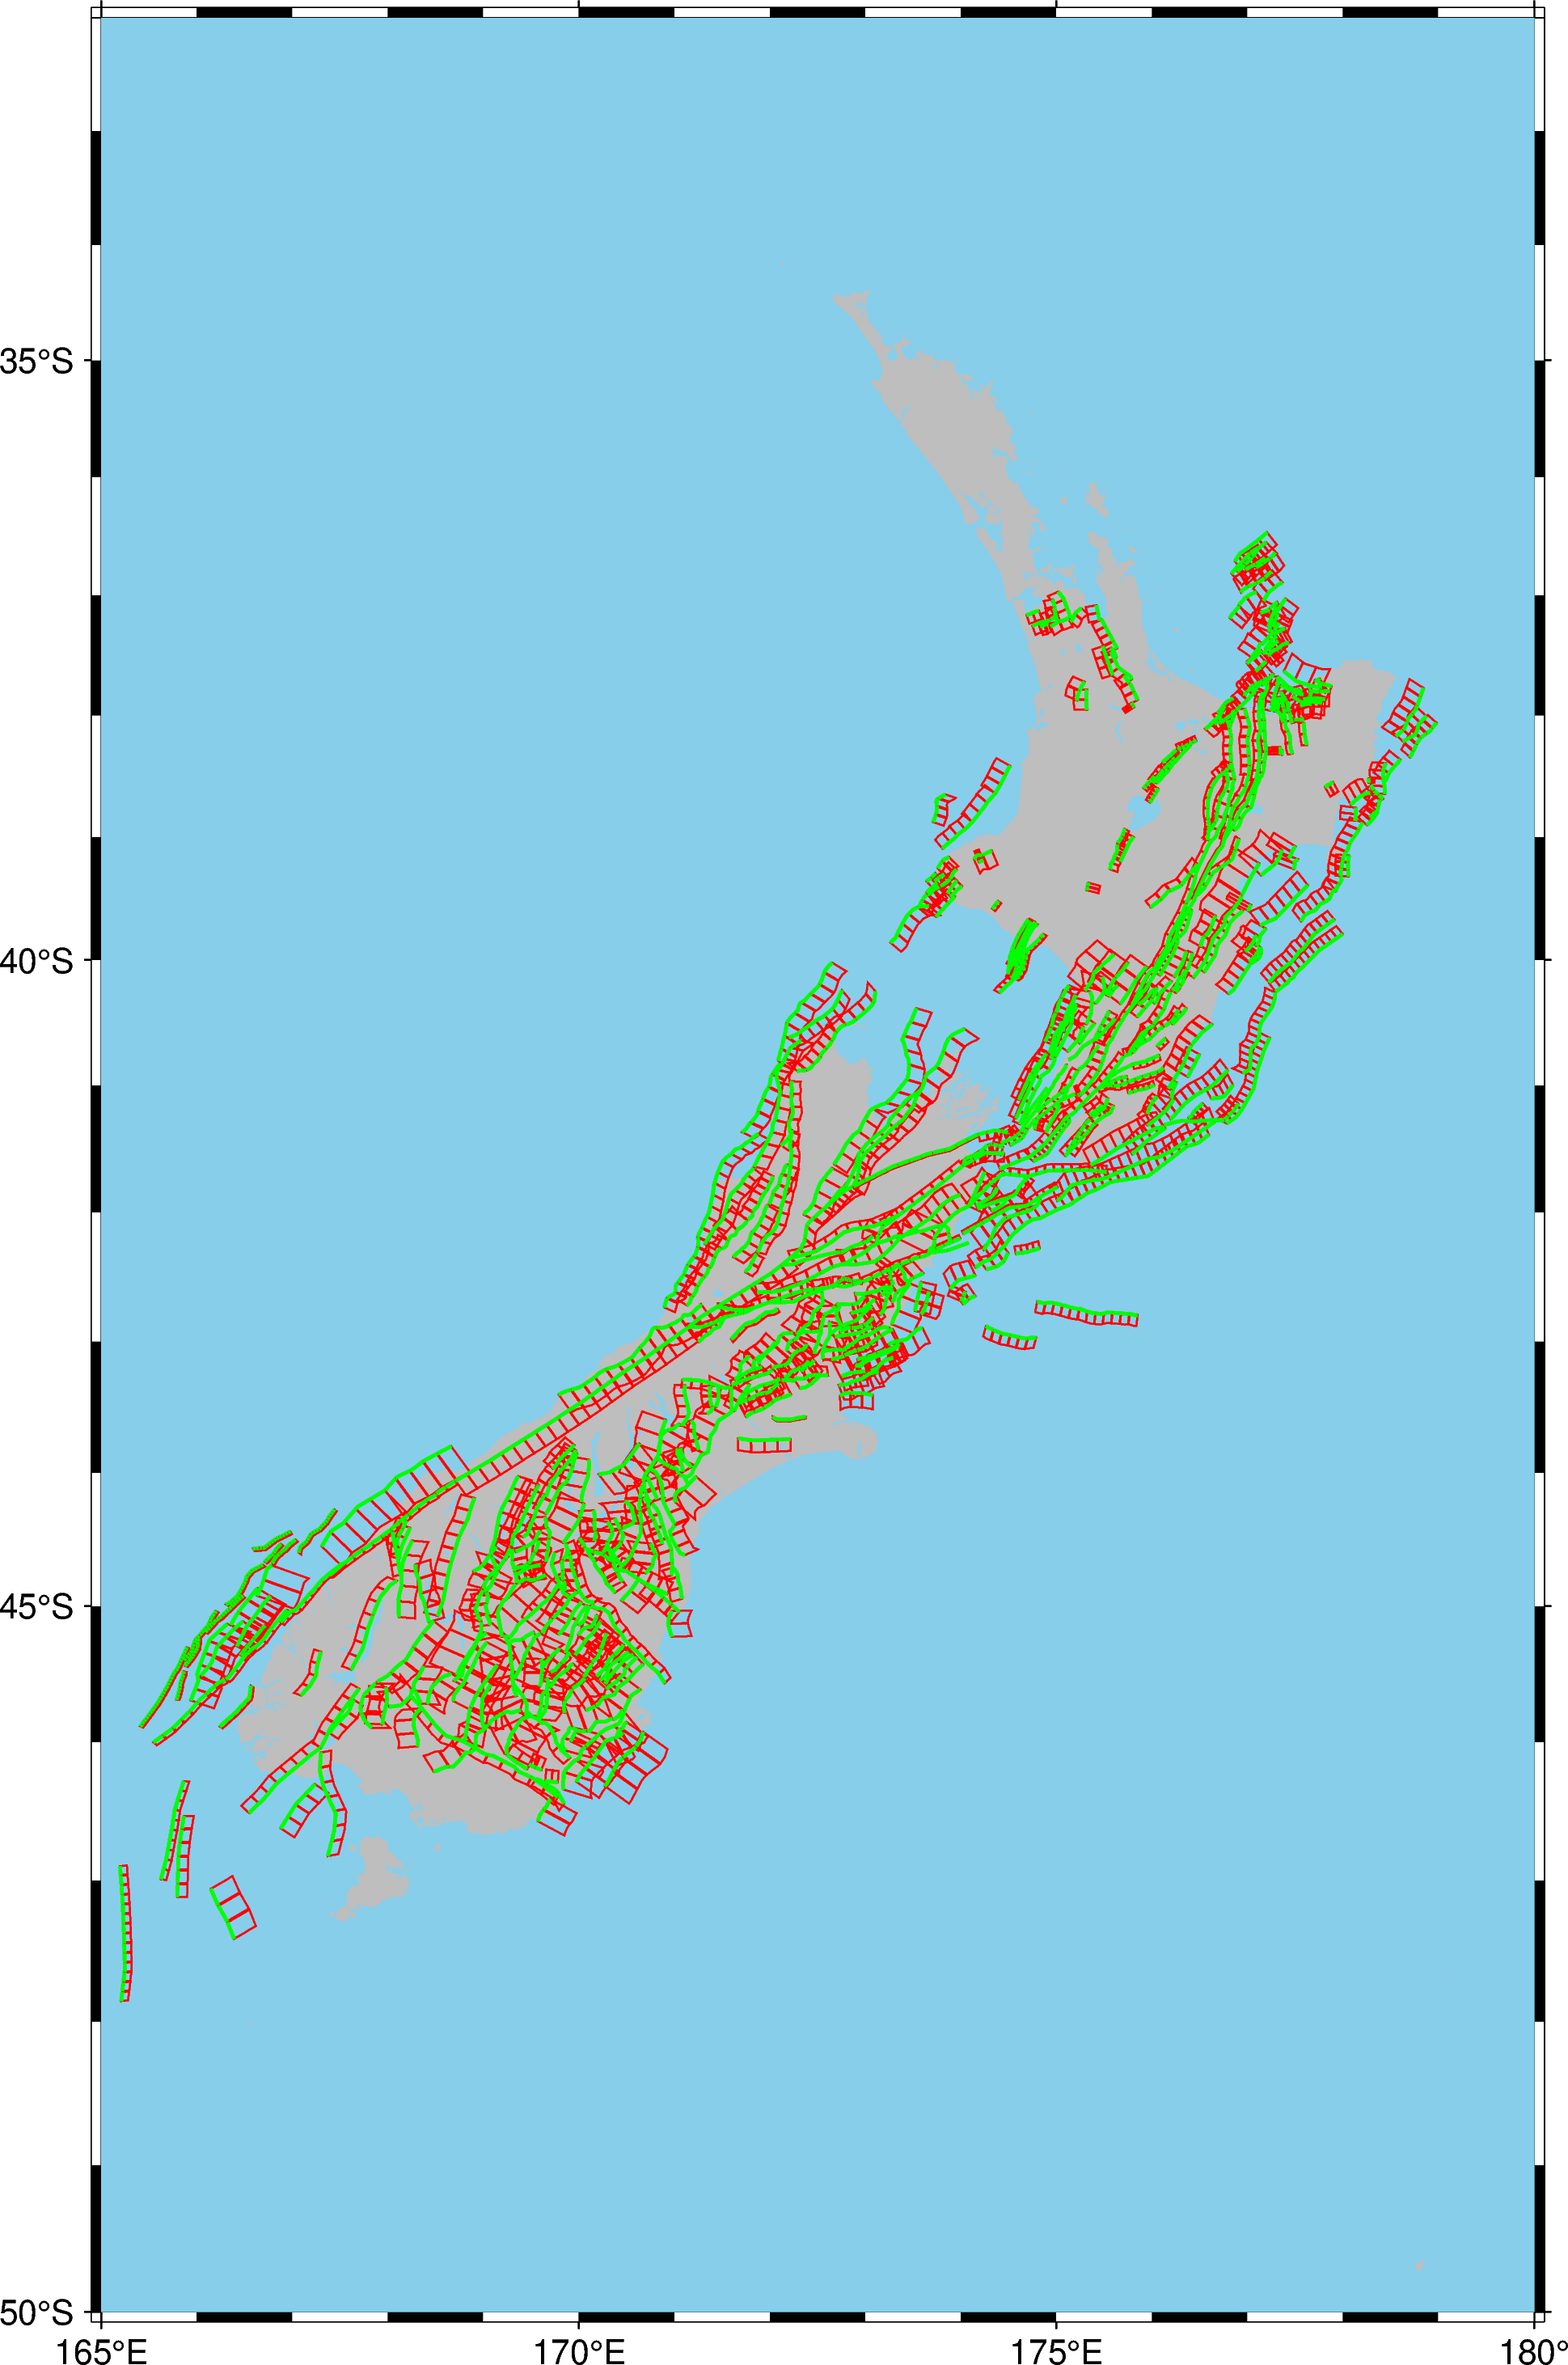

In [9]:
import pygmt 
region = [165, 180, -50, -32]
fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="grey", water="skyblue")
fig.plot(gdaf_polys, pen="0.5p,red")
fig.plot(gdaf_traces, pen="1p,green")
fig.show()

In [12]:
path = Path(fname_sections)
out_file_traces = path.stem + '_traces.geojson'
out_file_sections = path.stem + '_sections.geojson'
gdaf_traces.to_file(out_file_traces)
gdaf_polys.to_file(out_file_sections)

In [17]:
print(gdaf_traces.iloc[0]['geometry'])
print(gdaf_traces.iloc[1]['geometry'])

LINESTRING (168.3079673669224 -45.532089342591284, 168.31420746001314 -45.52427191928496, 168.320445824778 -45.5164541444555, 168.32668246209104 -45.50863601828863, 168.33291737282593 -45.500817540969926, 168.33915055785576 -45.49299871268487, 168.34601290892468 -45.48545627645299, 168.35331016784465 -45.47810498123844, 168.35842239140982 -45.4698384588589, 168.36271455076425 -45.46122868921213, 168.36681039330168 -45.45301011016613, 168.3711 -45.4444)
LINESTRING (168.28196985544773 -45.625065711753685, 168.27526051358373 -45.617239730546714, 168.26855303812198 -45.60941334464452, 168.2659904888321 -45.60183336113005, 168.26788724193605 -45.593033395886636, 168.26986239608303 -45.58386671746903, 168.27179027488293 -45.575075612347156, 168.2740731919246 -45.566382928601826, 168.2814126789715 -45.55871552272211, 168.28862351973012 -45.5515305810868, 168.29619292503887 -45.543985892854735, 168.3034 -45.5368)


In [19]:
(.3034-.30797)*111

-0.5072700000000021